In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CS114"

Mounted at /content/drive
/content/drive/MyDrive/CS114


In [3]:
!pip install ultralytics 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.7/303.7 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.7 MB/s eta 0:00:00


In [4]:
#import library
from ultralytics import YOLO
import numpy as np
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import torch
import matplotlib.pyplot as plt

In [5]:
dict_char = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6,
    7:7,
    8:8,
    9:9,
    10: 'A',
    11: 'C',
    12: 'D',
    13: 'E',
    14: 'G',
    15: 'H',
    16: 'K',
    17: 'R',
    18: 'S',
}

In [6]:
#set Model to detect License plate
model = YOLO("/content/drive/MyDrive/CS114/runs/detect/train5/weights/best.pt")
# set model parameters
model.overrides['conf'] = 0.45  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold

#set Model to detect character
model_char = YOLO("/content/drive/MyDrive/CS114/runs/detect/train6/weights/best.pt")
# set model parameters
model_char.overrides['conf'] = 0.85  # NMS confidence threshold
model_char.overrides['iou'] = 0.45  # NMS IoU threshold

In [7]:
def resize_img (image):
  h, w,_ = image.shape
  new_h = 256//h #256
  new_w = 256//w
  scale_num = max(new_h, new_w)
  width = int(image.shape[1] * scale_num)
  height = int(image.shape[0] * scale_num)
  dim = (width, height)
  ROI = cv2.resize(image, dim,interpolation = cv2.INTER_AREA)
  return ROI

In [8]:
def check_row(box1, box2):
    yi1 = max(box1[1],box2[1])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)
  
    box1_area = (box1[3]-box1[1])
    box2_area = (box2[3]-box2[1])
    union_area = box1_area+box2_area-inter_area
    
    iou = inter_area/union_area
    
    return iou

In [14]:
def Read_LP(image, option):

  #image = cv2.imread(path_img)
  #cv2_imshow(image)
  result=model.predict(image,save=False, save_txt=False, save_crop=False) #predict image and add bounding box
  arr_of_coor = []
  list_roi = []
  class_ls = []
  index = 0
  for i in result:
    print(i)
  
  #add coordinates to list
  for i in result:
    for j in i.boxes:
      arr_of_coor.append(sum(j.xyxy.tolist(),[])) #flatten
      class_ls.append(int(j.cls.item()))


  if option == 1:
    for i in arr_of_coor:
      i = list(map(int, i))
      x1 = i[0]
      y1 = i[1]
      x2 = i[2]
      y2 = i[3]
      ROI = image[y1:y2, x1:x2]

      ROI = resize_img(ROI)

      read_LP(ROI)
  elif option == 2:
    for i in arr_of_coor:
      i = list(map(int, i))
      if (class_ls[index] == 1):
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (255, 0, 0),3)
      elif (class_ls[index] == 2):
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0, 255, 0),3)
      elif (class_ls[index] == 3):
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0, 0, 255),3)
      elif (class_ls[index] == 4):
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (234, 221, 202),3)
      elif (class_ls[index] == 5):
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (159, 43, 104),3)
      index = index + 1
    cv2_imshow(image)

In [13]:
#RUN THIS
#image = cv2.imread("/content/download (59).png")
def read_LP(image):
  
  #model_char = YOLO("/content/drive/MyDrive/CS114/runs/detect/train6/weights/best.pt")
  # set model parameters
  #model_char.overrides['conf'] = 0.85  # NMS confidence threshold
  #model_char.overrides['iou'] = 0.45  # NMS IoU threshold
  #
  #path_img_char = "/content/download (69).png"
  kernel = np.ones((2,2),np.uint8)
  image = cv2.dilate(image,kernel,iterations = 2)

  result_char=model_char.predict(image,save=False, save_txt=False, save_crop=False)

  

  arr_of_coor_char = []
  cls_list = []

  for i in result_char:
    for j in i.boxes:
      
      arr_of_coor_char.append(sum(j.xyxy.tolist(),[])) #flatten
      cls_list.append(int(j.cls.item()))

  #RUN THIS
  index = 0
  LP_char_ls = []
  highest_box = (0,0,0,0)
  lowest_box = (10000,10000,10000,10000)
  for i in arr_of_coor_char:
    #convert to int
    i = list(map(int, i))
    #print(i)

    if i[1] < lowest_box[1]:
      lowest_box = (i[0],i[1],i[2],i[3])
    if i[3] > highest_box[3]:
      highest_box = (i[0],i[1],i[2],i[3])
    LP_char_ls.append(((i[0],i[1],i[2],i[3]),cls_list[index]))
    index=index+1
    #cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (255, 0, 0),1)


  row = check_row(lowest_box,highest_box )
  #print(row)
  if row>0:
    #neu chi co 1 dong thi doc tu trai sang phai
    LP_char_ls=sorted(LP_char_ls,key=lambda l:l[0][0], reverse=False)
    #print([i[1] for i in LP_char_ls])
    for i in LP_char_ls:
      temp = i[1]+0
      print(dict_char[temp],end='')
  else:
    #neu co 2 dong thi doc tu tren xuong
    LP_char_ls=sorted(LP_char_ls,key=lambda l:l[0][3], reverse=False)
    #print(LP_char_ls)
    #print([i[1] for i in LP_char_ls])
    for i in LP_char_ls:
      temp = i[1]+0
      print(dict_char[temp],end='')
  cv2_imshow(image)


0: 384x640 5 oto ca nhans, 1 quan doi, 4 xe may ca nhans, 399.4ms
Speed: 1.1ms preprocess, 399.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


{ '_keys': <generator object Results.__init__.<locals>.<genexpr> at 0x7f4aa0259eb0>,
  'boxes': Ultralytics YOLO Boxes
type: <class 'torch.Tensor'>
shape: torch.Size([10, 6])
dtype: torch.float32
 + tensor([[9.11000e+02, 6.87000e+02, 9.86000e+02, 7.70000e+02, 7.36448e-01, 1.00000e+00],
        [1.57100e+03, 4.00000e+02, 1.61300e+03, 4.45000e+02, 7.23389e-01, 1.00000e+00],
        [6.51000e+02, 5.81000e+02, 6.93000e+02, 6.27000e+02, 5.69085e-01, 5.00000e+00],
        [1.42200e+03, 7.67000e+02, 1.45800e+03, 8.07000e+02, 5.65393e-01, 5.00000e+00],
        [1.68200e+03, 9.52000e+02, 1.73900e+03, 1.00900e+03, 5.49471e-01, 5.00000e+00],
        [8.58000e+02, 3.65000e+02, 8.93000e+02, 4.01000e+02, 5.28655e-01, 1.00000e+00],
        [1.88100e+03, 7.11000e+02, 1.91700e+03, 7.54000e+02, 3.41847e-01, 5.00000e+00],
        [2.49000e+02, 6.21000e+02, 2.86000e+02, 6.56000e+02, 2.96169e-01, 1.00000e+00],
        [3.39000e+02, 6.35000e+02, 4.02000e+02, 7.09000e+02, 2.82848e-01, 1.00000e+00],
        [

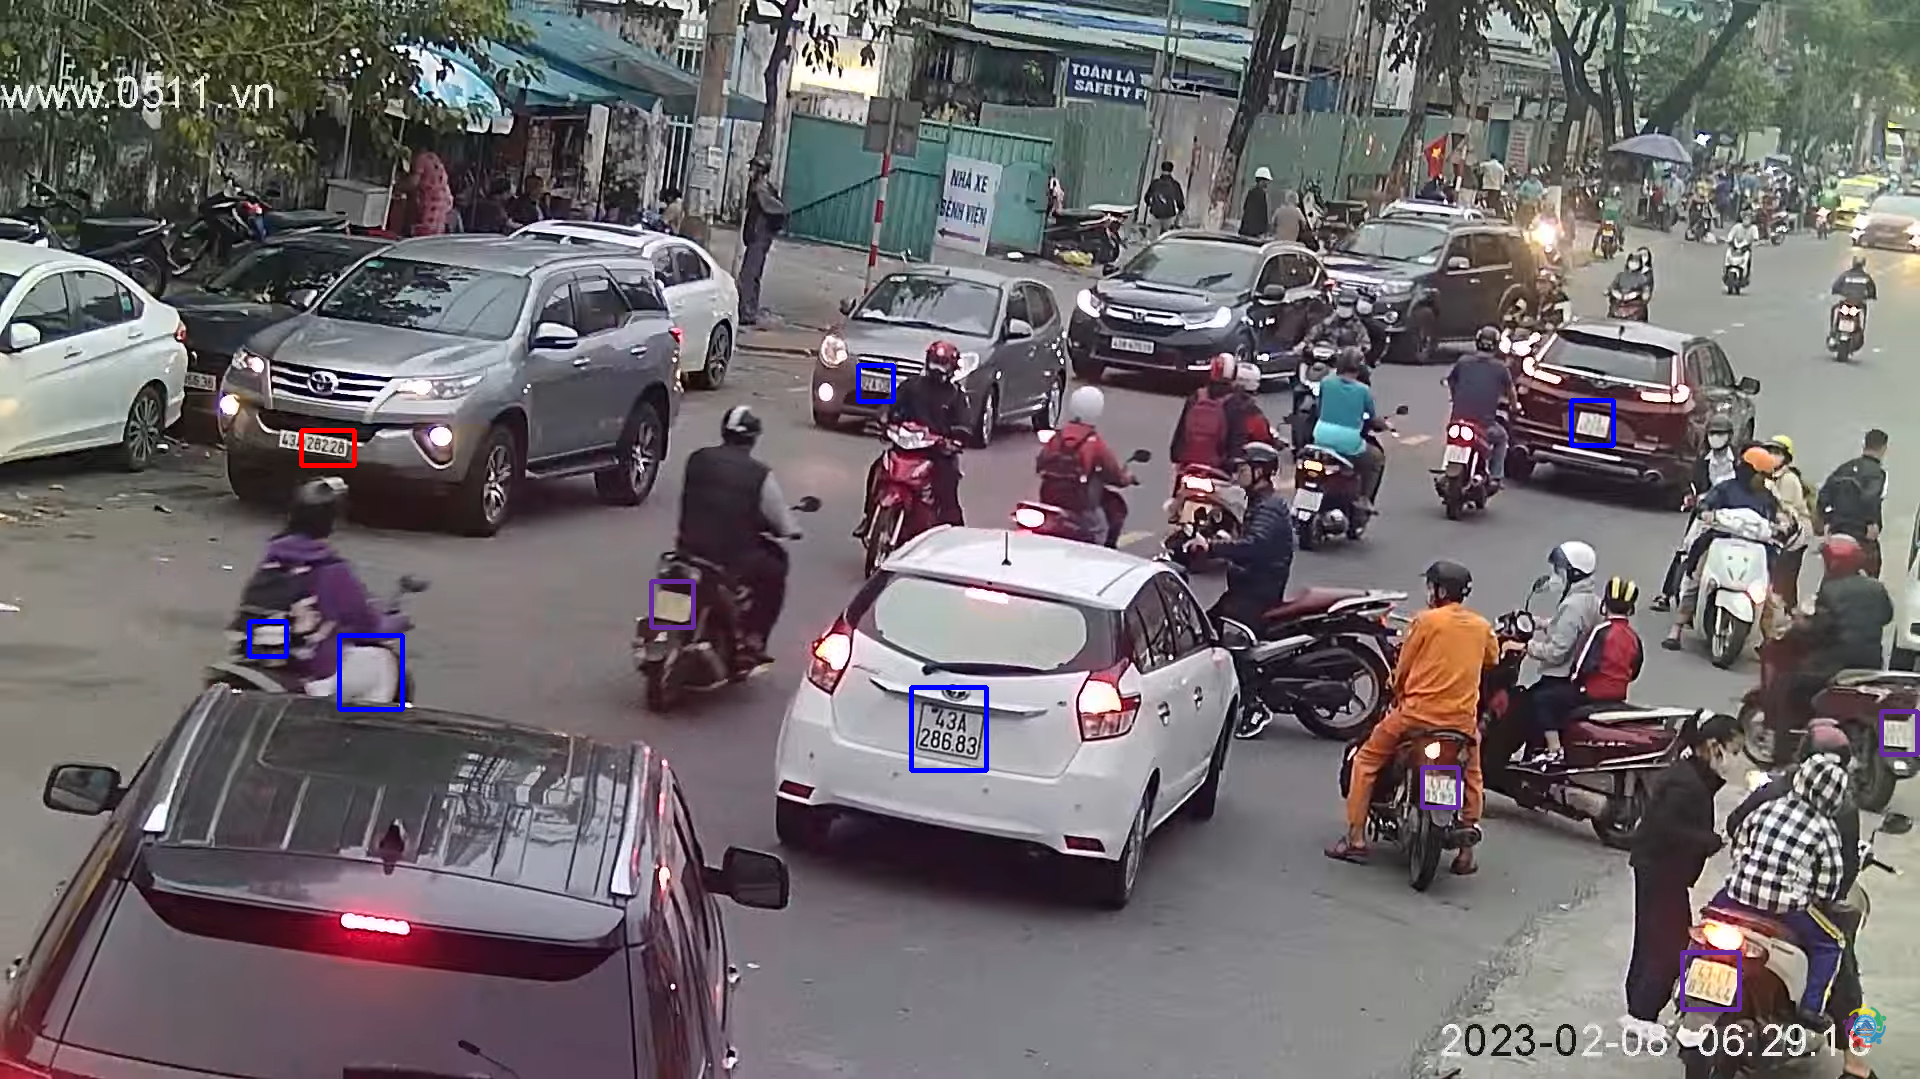

In [16]:
#imput_of_file = 
#path = "/content/drive/MyDrive/CS114/picture/Capture (41).PNG"
path = "/content/Capture (73).PNG"
src = cv2.imread(path)
#cv2_imshow(src)
#img = resize_img(src)
#print(img)
Read_LP(src,2)

Tài liệu tham khảo: 
https://github.com/ultralytics/ultralytics 

https://docs.ultralytics.com/

https://www.youtube.com/watch?v=wuZtUMEiKWY

https://www.youtube.com/watch?v=Mpsdby8zCTY
